# Import basic libraries and dependencies

In [1]:
import sys
import importlib
import sentencepiece as spm
import config

importlib.reload(config)
sys.path.append('./modules')
from config import English, Bengali

# Set a language

In [2]:
LANG = English # English, Bengali

# 1. Data Preparation

In [3]:
# import libraries and dependencies
import preprocessing
importlib.reload(preprocessing)
from preprocessing import raw_preprocess, split_train_test

## 1.1. Preprocess data for sentencepiece

In [4]:
# preprocess raw data to get a list of sentences.
sentences = raw_preprocess(LANG)

# write the sentences into a file, each sentence on one line.
with open(f'data/{LANG.name}_preprocessed.txt', 'w') as f:
    for sentence in sentences:
        f.write(f'{sentence}\n')

## 1.2. Train/test split

In [5]:
# split data to train and test.
train, test = split_train_test(sentences, LANG)

# write train and test data into corresponding files.
train_path = f'data/{LANG.name}_train.txt'
test_path = f'data/{LANG.name}_test.txt'

with open(train_path, 'w') as f:
    f.write('\n'.join(train))
with open(test_path, 'w') as f:
    f.write('\n'.join(test))

# 2. Subword segmentation

For English. we use a small subword vocabulary size of 500 and a large subword vocabulary size of 1500. For Bengali, these numbers are 800 and 1700.

In [6]:
# import libraries and dependencies
import segmentation
importlib.reload(segmentation)
from segmentation import train_segmentation, encode_text_file, decode_text_file
from config import seg_profiles

In [7]:
seg_profiles[LANG.name]

[SegmentationConf(id='s1', vocab_size=None, model_type='char'),
 SegmentationConf(id='s2', vocab_size=800, model_type='bpe'),
 SegmentationConf(id='s3', vocab_size=1700, model_type='bpe')]

In [ ]:
for seg in seg_profiles[LANG.name]:
    # train segmentation on the train data
    spm1 = train_segmentation(
        text_file=train_path, 
        LANG=LANG, 
        vocab_size=seg.vocab_size, 
        model_type=seg.model_type)
  
    encoded_file = f'data/{LANG.name}_{seg.id}.txt'
    encode_text_file(text_file=train_path, model_path=spm1, output_file=encoded_file)
    
    decoded_file = f'data/{LANG.name}_{seg.id}_decoded.txt'
    decode_text_file(text_file=encoded_file, model_path=spm1, output_file=decoded_file)
    
    # test it on the test data
    encoded_file = f'data/{LANG.name}_{seg.id}_test.txt'
    encode_text_file(text_file=test_path, model_path=spm1, output_file=encoded_file)
    
    decoded_file = f'data/{LANG.name}_{seg.id}_decoded_test.txt'
    decode_text_file(text_file=encoded_file, model_path=spm1, output_file=decoded_file)

# 3. Language Model

## Baseline

In [7]:
from config import baseline_conf
baseline_conf

TrainingConf(hidden=40, rand_seed=1, debug=2, bptt=4, n_class=9999)

In [ ]:
for seg in seg_profiles[LANG.name]:
    # Hyper parameters
    hidden = baseline_conf.hidden
    rand_seed = baseline_conf.rand_seed
    debug = baseline_conf.debug
    bptt = baseline_conf.bptt
    n_class = baseline_conf.n_class

    # Parameters
    model_path = f'models/rnnlm/{LANG.name}_{seg.id}_baseline'
    train_path = f'../../../data/{LANG.name}_{seg.id}.txt'
    valid_path = f'../../../data/{LANG.name}_{seg.id}_test.txt'

    # run the model 
    !rm -rf $model_path \
      && mkdir $model_path \
      && cd $model_path \
      && ../../../rnnlm-0.3e/rnnlm \
        -train $train_path \
        -valid $valid_path \
        -rnnlm model \
        -hidden $hidden \
        -rand-seed $rand_seed \
        -debug $debug \
        -bptt $bptt \
        -class $n_class
    
    # read output and print perplexity
    with open(f'{model_path}/model.output.txt', 'r') as f:
        output = f.read()
        pp = output.split()[-1]
        print(f'Baseline {LANG.name}-{seg.id} validation perplexity: {pp}')

## Experiments

In [8]:
import pickle
import itertools

In [6]:
# experimented results are kept in a file
grid_result_file = f'experiments/{LANG.name}_task3_grid_search.pickle'
# grid_results stores the results in memory
grid_results = {}

# import previous results if exists
try:
    with open(grid_result_file, 'rb') as f:
        previous_results = pickle.load(f)
        grid_results.update(previous_results)
except:
    pass #TODO: add exceptions etc.

print(grid_results[0:5])

{('en', 's1', 5, 0, 10): 10.887227, ('en', 's1', 5, 0, 100): 10.645946, ('en', 's1', 5, 0, 1501): 10.482386, ('en', 's1', 5, 1, 10): 10.605196, ('en', 's1', 5, 1, 100): 10.271953, ('en', 's1', 5, 1, 1501): 10.261143, ('en', 's1', 5, 3, 10): 10.650879, ('en', 's1', 5, 3, 100): 10.273488, ('en', 's1', 5, 3, 1501): 10.1756, ('en', 's1', 5, 5, 10): 10.650509, ('en', 's1', 5, 5, 100): 10.275037, ('en', 's1', 5, 5, 1501): 10.170872, ('en', 's1', 20, 0, 10): 7.372125, ('en', 's1', 20, 0, 100): 6.910608, ('en', 's1', 20, 0, 1501): 7.039472, ('en', 's1', 20, 1, 10): 6.759173, ('en', 's1', 20, 1, 100): 6.477795, ('en', 's1', 20, 1, 1501): 6.552387, ('en', 's1', 20, 3, 10): 6.617757, ('en', 's1', 20, 3, 100): 6.550642, ('en', 's1', 20, 3, 1501): 6.441925, ('en', 's1', 20, 5, 10): 6.675042, ('en', 's1', 20, 5, 100): 6.571401, ('en', 's1', 20, 5, 1501): 6.611228, ('en', 's1', 40, 0, 10): 6.051518, ('en', 's1', 40, 0, 100): 5.971961, ('en', 's1', 40, 0, 1501): 5.99838, ('en', 's1', 40, 1, 10): 5.437

In [ ]:
hidden_choices = [5, 20, 40, 70, 100, 150, 200]
bptt_choices = [0, 1, 3, 5]
class_choices = [10, 100, 1501]
rand_seed = 1
debug = 2

for seg, hidden, bptt, _class in itertools.product(
    seg_profiles[LANG.name], hidden_choices, bptt_choices, class_choices):

    if (LANG.name, seg.id, hidden, bptt, _class) in grid_results:
        print(f'skip {LANG.name} {seg.id} {hidden} {bptt} {_class}')
        continue

    # Parameters
    model_path = f'models/rnnlm/{LANG.name}_{seg.id}'
    train_path = f'../../../data/{LANG.name}_{seg.id}.txt'
    valid_path = f'../../../data/{LANG.name}_{seg.id}_test.txt'

    # run the model 
    !rm -rf $model_path \
      && mkdir $model_path \
      && cd $model_path \
      && ../../../rnnlm-0.3e/rnnlm \
        -train $train_path \
        -valid $valid_path \
        -rnnlm model \
        -hidden $hidden \
        -rand-seed $rand_seed \
        -debug $debug \
        -bptt $bptt \
        -class $_class \
        2> error.txt

    # read output extract validation perplexity
    with open(f'{model_path}/model.output.txt', 'r') as f:
        output = f.read()
        pp = float(output.split()[-1])
        grid_results[(LANG.name, seg.id, hidden, bptt, _class)] = pp

    # write current results to file
    with open(grid_result_file, 'wb') as f:
        pickle.dump(grid_results, f)

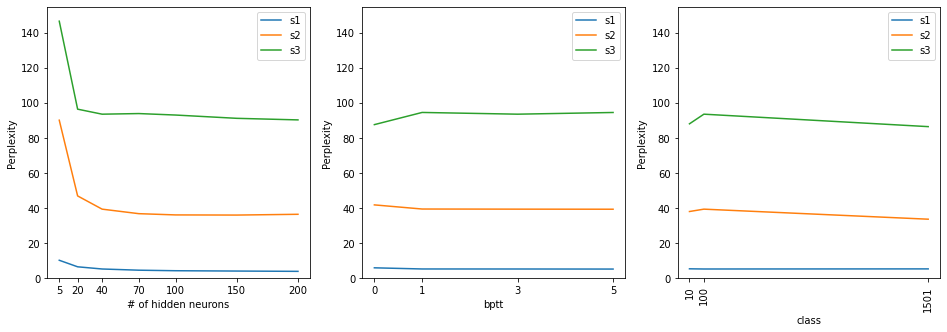

In [28]:
import visualization 
visualization = importlib.reload(visualization)

visualization.plot_grid_results(grid_results)

The optimal configurations of hyperparameters for each vocabulary size are:

In [12]:
for seg in seg_profiles:
    results = dict((k, v) for (k, v) in grid_results.items() if k[1] == seg.id)
    print(f"{seg.id}: {min(results, key=results.get)}")

s1: ('en', 's1', 200, 3, 100)
s2: ('en', 's2', 200, 3, 1501)
s3: ('en', 's3', 40, 0, 1501)


In [18]:
# train and save LMs for the optimal configurations
importlib.reload(config)
from config import optimal_conf

for id, (hidden, rand_seed, debug, bptt, n_class) in \
    enumerate(optimal_conf[LANG.name], start=1):
    
    seg_id = f's{id}'

    # paths
    model_path = f'models/rnnlm/{LANG.name}_{seg_id}_optimal'
    train_path = f'../../../data/{LANG.name}_{seg_id}.txt'
    valid_path = f'../../../data/{LANG.name}_{seg_id}_test.txt'

    # run the model 
    !rm -rf $model_path \
      && mkdir $model_path \
      && cd $model_path \
      && ../../../rnnlm-0.3e/rnnlm \
        -train $train_path \
        -valid $valid_path \
        -rnnlm model \
        -hidden $hidden \
        -rand-seed $rand_seed \
        -debug $debug \
        -bptt $bptt \
        -class $n_class

debug mode: 2
train file: ../../../data/en_s1.txt
valid file: ../../../data/en_s1_test.txt
class size: 100
Hidden layer size: 200
BPTT: 3
Rand seed: 1
rnnlm file: model
Starting training using file ../../../data/en_s1.txt
Vocab size: 72
Words in train file: 115565
Iter:   0	Alpha: 0.100000	   TRAIN entropy: 3.1770    Words/sec: 9620.3   VALID entropy: 2.7640
Iter:   1	Alpha: 0.100000	   TRAIN entropy: 2.6055    Words/sec: 9618.7   VALID entropy: 2.5331
Iter:   2	Alpha: 0.100000	   TRAIN entropy: 2.4166    Words/sec: 9598.8   VALID entropy: 2.4186
Iter:   3	Alpha: 0.100000	   TRAIN entropy: 2.3017    Words/sec: 9669.8   VALID entropy: 2.3476
Iter:   4	Alpha: 0.100000	   TRAIN entropy: 2.2207    Words/sec: 9582.0   VALID entropy: 2.2939
Iter:   5	Alpha: 0.100000	   TRAIN entropy: 2.1579    Words/sec: 9569.7   VALID entropy: 2.2625
Iter:   6	Alpha: 0.100000	   TRAIN entropy: 2.1089    Words/sec: 9481.0   VALID entropy: 2.2430
Iter:   7	Alpha: 0.100000	   TRAIN entropy: 2.0687    Words/sec

# 4. Text Generation

In [50]:
for seg in seg_profiles[LANG.name]:
    gen_folder = f'data/generation/{LANG.name}_{seg.id}'
    # path to LM file
    language_model_file = f'models/rnnlm/{LANG.name}_{seg.id}_optimal/model'
    # path to segmentation file
    if seg.model_type == 'char':
        seg_model_file = f'{LANG.seg_model_folder}/spm_{LANG.name}_{seg.model_type}.model'
    else:
        seg_model_file = f'{LANG.seg_model_folder}/spm_{LANG.name}_{seg.model_type}_vocabsize-{seg.vocab_size}.model'
    
    # remove the text-generation folder
    !rm -rf $gen_folder \
        && mkdir $gen_folder
    
    for n_gen in [10, 100, 1000, 10000, 100000, 1000000, 10000000]:
        # generate text using rnnlm
        gen_file = f'{gen_folder}/{LANG.name}_{seg.id}_{n_gen}.txt'
        !rnnlm-0.3e/rnnlm \
                -rnnlm $language_model_file \
                -gen $n_gen \
                -debug 0 \
            > $gen_file
        
        # decode generated text using sentencepiece
        decoded_gen_file = f'{gen_folder}/{LANG.name}_{seg.id}_{n_gen}_decoded.txt'
        decode_text_file(gen_file, seg_model_file, decoded_gen_file)

# 5. OOV comparison

## Original data

In [52]:
import nltk
from vocab_processing import get_word_level_vocabulary, get_word_level_tokens, get_OOV_rate

In [53]:
train_path = f'data/{LANG.name}_train.txt'
test_path = f'data/{LANG.name}_test.txt'

In [54]:
# get the training vocabulary on word-level
train_vocab = get_word_level_vocabulary(LANG, train_path)
# get the test tokens on word-level
test_tokens = get_word_level_tokens(LANG, test_path)
# compute and print OOV rate
oov_tokens = get_OOV_rate(train_vocab, test_tokens)
print(f'Original data\'s OOV rate: {oov_rate:.2%}')

Original data's OOV rate: 4.61%


## Augment vocabulary with generated data

In [72]:
oov_rates = []

for seg in seg_profiles[LANG.name]:
    gen_folder = f'data/generation/{LANG.name}_{seg.id}'
    oov_rates.append([])
    
    for n_gen in [10, 100, 1000, 10000, 100000, 1000000, 10000000]:
        decoded_gen_file = f'{gen_folder}/{LANG.name}_{seg.id}_{n_gen}_decoded.txt'
        gen_vocab = get_word_level_vocabulary(LANG, decoded_gen_file)
        augmented_oov_rate = get_OOV_rate(train_vocab | gen_vocab, test_tokens)
        print(f'{LANG.name} {seg.id} {n_gen} OOV rate: {augmented_oov_rate:.2%}')
        oov_rates[-1].append(augmented_oov_rate)

en s1 10 OOV rate: 4.61%
en s1 100 OOV rate: 4.61%
en s1 1000 OOV rate: 4.61%
en s1 10000 OOV rate: 4.61%
en s1 100000 OOV rate: 4.52%
en s1 1000000 OOV rate: 3.89%
en s1 10000000 OOV rate: 3.03%
en s2 10 OOV rate: 4.61%
en s2 100 OOV rate: 4.61%
en s2 1000 OOV rate: 4.61%
en s2 10000 OOV rate: 4.59%
en s2 100000 OOV rate: 4.28%
en s2 1000000 OOV rate: 3.55%
en s2 10000000 OOV rate: 2.76%
en s3 10 OOV rate: 4.61%
en s3 100 OOV rate: 4.61%
en s3 1000 OOV rate: 4.61%
en s3 10000 OOV rate: 4.55%
en s3 100000 OOV rate: 4.37%
en s3 1000000 OOV rate: 3.82%
en s3 10000000 OOV rate: 3.07%


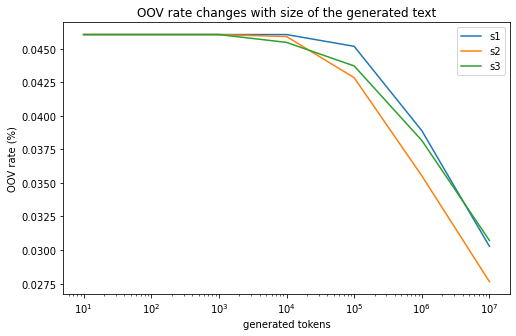

In [76]:
import visualization
importlib.reload(visualization)
from visualization import plot_oov_rates

plot_oov_rates(oov_rates)
# plot_oov_rates(oov_rates, save_path=f'figures/{LANG.name}_task5_oov_rates.png')